In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future

# !wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

In [4]:
# !unzip -n ml-20m.zip

In [5]:
# !ls

In [6]:
import os

In [7]:
os.getcwd()

'/Users/Z0094BV'

In [8]:
df = pd.read_csv('ml-20m/ratings.csv')
#df = pd.read_csv('ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [9]:
movie_titles = pd.read_csv('ml-20m/movies.csv')
#movie_titles = pd.read_csv('ml-latest-small/movies.csv')
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [11]:
#df.userId.cat.codes[56957]

In [12]:
#df.userId.cat.codes

In [13]:
#df['new_user_id'].shape

In [14]:
# Now do the same thing for movie ids
# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#   global current_movie_id, custom_movie_map
#   old_movie_id = row['movieId']
#   if old_movie_id not in custom_movie_map:
#     custom_movie_map[old_movie_id] = current_movie_id
#     current_movie_id += 1
#   return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [15]:
np.unique(df.movieId.cat.codes)

array([    0,     1,     2, ..., 26741, 26742, 26743], dtype=int16)

In [16]:
np.unique(df['movieId'])

array([     1,      2,      3, ..., 131258, 131260, 131262])

In [17]:
np.max(df['movieId'].astype(int))

131262

In [18]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [19]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [20]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0, 1) leads to poor results
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
  
  def forward(self, u, m):
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)

    # merge
    out = torch.cat((u, m), 1) # output is (num_samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [23]:
# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [24]:
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # get the batch
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      # convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    # we could do this if the test set size was manageable
    # test_outputs = model(test_users, test_movies)
    # test_loss = criterion(test_outputs, test_ratings).item()
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # get the batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      # conver to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      outputs = model(users, movies)
      loss = criterion(outputs, targets).item()
      test_loss.append(loss)
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test RMSE: {np.sqrt(test_loss):.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [25]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [26]:
Ntrain = int(0.75 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    epochs=10)

Epoch 1/10, Train Loss: 0.7447, Test Loss: 0.6963, Test RMSE: 0.8344, Duration: 0:07:05.406941
Epoch 2/10, Train Loss: 0.6749, Test Loss: 0.6718, Test RMSE: 0.8196, Duration: 0:06:22.284028
Epoch 3/10, Train Loss: 0.6410, Test Loss: 0.6506, Test RMSE: 0.8066, Duration: 0:06:19.912313
Epoch 4/10, Train Loss: 0.6185, Test Loss: 0.6602, Test RMSE: 0.8125, Duration: 0:06:19.679920
Epoch 5/10, Train Loss: 0.6019, Test Loss: 0.6366, Test RMSE: 0.7979, Duration: 0:06:21.069368
Epoch 6/10, Train Loss: 0.5880, Test Loss: 0.6351, Test RMSE: 0.7969, Duration: 0:06:18.713324
Epoch 7/10, Train Loss: 0.5775, Test Loss: 0.6342, Test RMSE: 0.7964, Duration: 0:06:20.102975
Epoch 8/10, Train Loss: 0.5692, Test Loss: 0.6309, Test RMSE: 0.7943, Duration: 0:06:20.004367
Epoch 9/10, Train Loss: 0.5626, Test Loss: 0.6298, Test RMSE: 0.7936, Duration: 0:06:21.914215
Epoch 10/10, Train Loss: 0.5572, Test Loss: 0.6306, Test RMSE: 0.7941, Duration: 0:06:21.503945


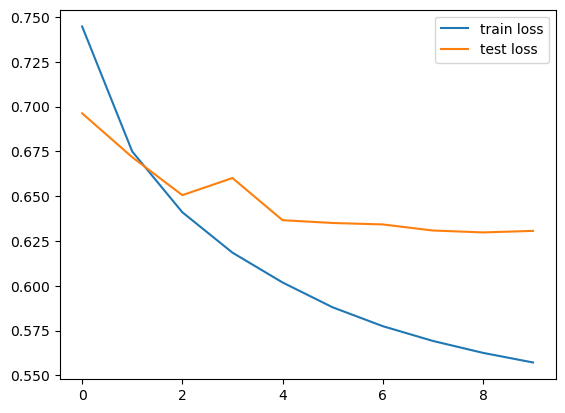

In [27]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [28]:
# Suppose I want to find recommendations for user_id = 1
# First find all the movie_ids for movies they haven't yet watched
# watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values


new_user = 409

watched_movie_ids = df[df.new_user_id == new_user].new_movie_id.values

In [29]:
watched_movie_ids

array([   49,   315,   587,   737,   786,   843,   895,   924,  1012,
        1113,  1173,  1178,  1354,  2400,  2486,  2702,  2712,  2941,
        4116,  4544,  4877,  4897,  5219,  7041,  7422,  9748, 10263,
       10747], dtype=int16)

In [30]:
old_user = np.unique(df[df['new_user_id'].isin([new_user])]['userId'])[0]
old_user

410

In [31]:
old_watched_movie_ids = np.unique(df[df.userId == old_user].movieId.values)
old_watched_movie_ids

array([   50,   318,   593,   750,   799,   858,   912,   941,  1031,
        1136,  1198,  1203,  1385,  2485,  2571,  2788,  2798,  3028,
        4210,  4639,  4973,  4993,  5316,  7153,  7701, 31685, 34332,
       42738])

In [32]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()
potential_movie_ids

array([    1,    28,    31, ..., 25231, 22980, 23071], dtype=int16)

In [33]:
# How many?
potential_movie_ids.shape

(26716,)

In [34]:
len(set(potential_movie_ids))

26716

In [35]:
# Repeat the user id this many times
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [36]:
# Convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# Get predictions
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

In [37]:
# Convert predictions to Numpy
predictions_np = predictions.cpu().numpy().flatten()

# Get sort index for predictions
sort_idx = np.argsort(-predictions_np)

In [38]:
predictions_np

array([1.387604 , 1.1890123, 1.9448485, ..., 1.4188615, 1.3864963,
       1.4282101], dtype=float32)

In [39]:
sort_idx

array([ 258, 5240, 2067, ..., 2816, 8828, 8616])

In [40]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print("movie:", movie, "score:", score)

movie: 1195 score: 2.9482017
movie: 18642 score: 2.853569
movie: 7356 score: 2.8437314
movie: 1183 score: 2.838786
movie: 293 score: 2.7972589
movie: 1176 score: 2.7567577
movie: 1222 score: 2.7563262
movie: 1182 score: 2.742806
movie: 109 score: 2.7158701
movie: 1187 score: 2.7155962


In [41]:
top_10_movie_ids

array([ 1195, 18642,  7356,  1183,   293,  1176,  1222,  1182,   109,
        1187], dtype=int16)

In [42]:
old_top_10_movie_ids = np.unique(df[df['new_movie_id'].isin(top_10_movie_ids)]['movieId'])
old_top_10_movie_ids

array([  111,   296,  1201,  1208,  1209,  1213,  1221,  1250,  7502,
       93040])

In [43]:
#df[['']]

In [44]:
#movie_titles = pd.read_csv('ml-latest-small/movies.csv')
#movie_titles.head()

In [45]:
movie_titles[movie_titles['movieId'].isin(old_watched_movie_ids)]

,movieId,title,genres
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
315,318,"Shawshank Redemption, The (1994)",Crime|Drama
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
737,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
786,799,"Frighteners, The (1996)",Comedy|Horror|Thriller
843,858,"Godfather, The (1972)",Crime|Drama
895,912,Casablanca (1942),Drama|Romance
924,941,"Mark of Zorro, The (1940)",Adventure
1012,1031,Bedknobs and Broomsticks (1971),Adventure|Children|Musical
1113,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy


In [46]:
movie_titles[movie_titles['movieId'].isin(old_top_10_movie_ids)]

,movieId,title,genres
109,111,Taxi Driver (1976),Crime|Drama|Thriller
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1176,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western
1182,1208,Apocalypse Now (1979),Action|Drama|War
1183,1209,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western
1187,1213,Goodfellas (1990),Crime|Drama
1195,1221,"Godfather: Part II, The (1974)",Crime|Drama
1222,1250,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War
7356,7502,Band of Brothers (2001),Action|Drama|War
18691,93040,"Civil War, The (1990)",Documentary|War


In [47]:
#df[df['userId']==410]

In [48]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [49]:
len(np.unique(df['movieId']))

26744

In [50]:
len(np.unique(df['new_movie_id']))

26744

In [51]:
len(np.unique(df[['movieId']]))

26744

In [52]:
len(np.unique(df[['new_movie_id']]))

26744

In [53]:
model.m_emb.weight.data

tensor([[ 7.5565e-01,  9.4934e-03,  3.3299e-01,  ...,  7.3783e-02,
         -2.7331e-01,  3.3759e-01],
        [ 4.1468e-01, -2.9044e-01,  3.6231e-01,  ..., -2.7115e-01,
          7.6422e-02,  3.3291e-01],
        [ 2.9028e-01, -2.8798e-01,  5.8448e-01,  ..., -3.4850e-02,
          1.7737e-01, -1.1571e-01],
        ...,
        [-2.8242e-02, -2.8911e-02,  1.6274e-02,  ..., -2.4497e-02,
         -7.4020e-04, -2.4930e-02],
        [ 1.4894e-03, -1.6868e-02, -1.1050e-02,  ...,  1.1315e-02,
          1.5845e-03,  2.2897e-05],
        [-1.0037e-02,  3.3327e-03, -8.3054e-03,  ..., -1.7367e-02,
          3.7214e-03, -1.4781e-03]])

In [54]:
m_emb_df = pd.DataFrame(model.m_emb.weight.data)
m_emb_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.755648,0.009493,0.332995,0.513148,-0.318559,-0.059483,0.535923,0.073783,-0.273309,0.337594
1,0.414684,-0.290441,0.362313,0.023067,0.438628,-0.079676,-0.201490,-0.271150,0.076422,0.332914
2,0.290285,-0.287977,0.584475,0.077406,0.209892,-0.085441,-0.019947,-0.034850,0.177366,-0.115713
3,0.092533,-0.242983,-0.022902,-0.158470,0.218544,-0.329362,-0.077028,-0.189334,0.325172,-0.284711
4,0.419555,-0.261300,0.434718,0.024742,0.165822,-0.208179,0.003390,-0.236338,0.282708,-0.149998


In [55]:
m_emb_df['movieId'] = np.unique(df[['movieId']])

In [56]:
m_emb_df['new_movie_id'] = np.unique(df[['new_movie_id']])

In [57]:
m_emb_df.shape

(26744, 12)

In [58]:
m_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id
0,0.755648,0.009493,0.332995,0.513148,-0.318559,-0.059483,0.535923,0.073783,-0.273309,0.337594,1,0
1,0.414684,-0.290441,0.362313,0.023067,0.438628,-0.079676,-0.201490,-0.271150,0.076422,0.332914,2,1
2,0.290285,-0.287977,0.584475,0.077406,0.209892,-0.085441,-0.019947,-0.034850,0.177366,-0.115713,3,2
3,0.092533,-0.242983,-0.022902,-0.158470,0.218544,-0.329362,-0.077028,-0.189334,0.325172,-0.284711,4,3
4,0.419555,-0.261300,0.434718,0.024742,0.165822,-0.208179,0.003390,-0.236338,0.282708,-0.149998,5,4


In [59]:
m_emb_df = pd.merge(m_emb_df, movie_titles, how='inner', left_on = ['movieId'], right_on = ['movieId'], right_index = False)


In [60]:
m_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,title,genres
0,0.755648,0.009493,0.332995,0.513148,-0.318559,-0.059483,0.535923,0.073783,-0.273309,0.337594,1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0.414684,-0.290441,0.362313,0.023067,0.438628,-0.079676,-0.201490,-0.271150,0.076422,0.332914,2,1,Jumanji (1995),Adventure|Children|Fantasy
2,0.290285,-0.287977,0.584475,0.077406,0.209892,-0.085441,-0.019947,-0.034850,0.177366,-0.115713,3,2,Grumpier Old Men (1995),Comedy|Romance
3,0.092533,-0.242983,-0.022902,-0.158470,0.218544,-0.329362,-0.077028,-0.189334,0.325172,-0.284711,4,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,0.419555,-0.261300,0.434718,0.024742,0.165822,-0.208179,0.003390,-0.236338,0.282708,-0.149998,5,4,Father of the Bride Part II (1995),Comedy


In [61]:
# Principal Component Analysis to represent word embeddings in 2-D
from sklearn.decomposition import PCA
from matplotlib import pyplot
X = model.m_emb.weight.data
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [62]:
#result_sample = result.sample(50)

In [63]:
list(m_emb_df['title'][0:50])

['Toy Story (1995)',
 'Jumanji (1995)',
 'Grumpier Old Men (1995)',
 'Waiting to Exhale (1995)',
 'Father of the Bride Part II (1995)',
 'Heat (1995)',
 'Sabrina (1995)',
 'Tom and Huck (1995)',
 'Sudden Death (1995)',
 'GoldenEye (1995)',
 'American President, The (1995)',
 'Dracula: Dead and Loving It (1995)',
 'Balto (1995)',
 'Nixon (1995)',
 'Cutthroat Island (1995)',
 'Casino (1995)',
 'Sense and Sensibility (1995)',
 'Four Rooms (1995)',
 'Ace Ventura: When Nature Calls (1995)',
 'Money Train (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Assassins (1995)',
 'Powder (1995)',
 'Leaving Las Vegas (1995)',
 'Othello (1995)',
 'Now and Then (1995)',
 'Persuasion (1995)',
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Dangerous Minds (1995)',
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 'Wings of Courage (1995)',
 'Babe (1995)',
 'Carrington (1995)',
 'Dead Man Walking (1995)',
 'Across the Sea of 

In [64]:
result[:50, 0]

array([ 0.57517749, -0.32458447, -0.37948295, -0.45521942, -0.39203405,
        0.39499634, -0.19842171, -0.3694542 , -0.46710146, -0.09713042,
        0.02974794, -0.48300323, -0.16406   ,  0.37788864, -0.56136667,
        0.43425859,  0.38174075, -0.08439048, -0.58196189, -0.54324994,
        0.36428068, -0.10976752, -0.40148547, -0.23615912,  0.55885965,
        0.16667285, -0.27165965,  0.36407258,  0.49372348,  0.20952425,
       -0.23985271,  0.59841726, -0.10417325,  0.41741991,  0.05221166,
        0.70058195, -0.14857681, -0.51055669,  0.16975234,  0.07589188,
        0.44208118, -0.14749578,  0.03963199, -0.5712308 ,  0.3322317 ,
       -0.28224666,  0.55561854, -0.44761998,  0.06384985,  0.61747217])

In [65]:
result[:50, 1]

array([ 0.86206195,  0.54324649,  0.4717197 , -0.05456024,  0.46320346,
        0.47554175,  0.63585559,  0.22815275,  0.30390511,  0.70771924,
        0.88581259, -0.05791681,  0.18151181,  0.22804297,  0.19562215,
        0.27219259,  0.2803829 ,  0.01151061, -0.06506311,  0.21581964,
        0.41353771,  0.56132175,  0.34041322,  0.36268597,  0.03352138,
        0.2106147 ,  0.21938309,  0.07880596, -0.19823062, -0.1780354 ,
        0.39609511,  0.25468169,  0.23116147,  0.40856713, -0.11384121,
        0.34014032,  0.17489963,  0.01400022,  0.25111571, -0.01796672,
       -0.01017599, -0.08005208,  0.12898796,  0.14715385, -0.06470217,
        0.17527409,  0.26457252,  0.32616684, -0.07225612,  0.2897546 ])

In [66]:
m_emb_df['pca_1'] = result[:, 0]
m_emb_df['pca_2'] = result[:, 1]

In [67]:
m_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,title,genres,pca_1,pca_2
0,0.755648,0.009493,0.332995,0.513148,-0.318559,-0.059483,0.535923,0.073783,-0.273309,0.337594,1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.575177,0.862062
1,0.414684,-0.290441,0.362313,0.023067,0.438628,-0.079676,-0.201490,-0.271150,0.076422,0.332914,2,1,Jumanji (1995),Adventure|Children|Fantasy,-0.324584,0.543246
2,0.290285,-0.287977,0.584475,0.077406,0.209892,-0.085441,-0.019947,-0.034850,0.177366,-0.115713,3,2,Grumpier Old Men (1995),Comedy|Romance,-0.379483,0.471720
3,0.092533,-0.242983,-0.022902,-0.158470,0.218544,-0.329362,-0.077028,-0.189334,0.325172,-0.284711,4,3,Waiting to Exhale (1995),Comedy|Drama|Romance,-0.455219,-0.054560
4,0.419555,-0.261300,0.434718,0.024742,0.165822,-0.208179,0.003390,-0.236338,0.282708,-0.149998,5,4,Father of the Bride Part II (1995),Comedy,-0.392034,0.463203


In [68]:
m_emb_df['year'] = pd.to_numeric(m_emb_df['title'].str[-6::].str.replace("(",'').str.replace(")",'').str.replace("-",''), errors='coerce').fillna(0).astype('int')
m_emb_df.head()


/var/folders/0y/mqv6hsyx3xq_llz15k7nfxxc0000gp/T/ipykernel_23832/616065709.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  m_emb_df['year'] = pd.to_numeric(m_emb_df['title'].str[-6::].str.replace("(",'').str.replace(")",'').str.replace("-",''), errors='coerce').fillna(0).astype('int')


,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,title,genres,pca_1,pca_2,year
0,0.755648,0.009493,0.332995,0.513148,-0.318559,-0.059483,0.535923,0.073783,-0.273309,0.337594,1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.575177,0.862062,1995
1,0.414684,-0.290441,0.362313,0.023067,0.438628,-0.079676,-0.201490,-0.271150,0.076422,0.332914,2,1,Jumanji (1995),Adventure|Children|Fantasy,-0.324584,0.543246,1995
2,0.290285,-0.287977,0.584475,0.077406,0.209892,-0.085441,-0.019947,-0.034850,0.177366,-0.115713,3,2,Grumpier Old Men (1995),Comedy|Romance,-0.379483,0.471720,1995
3,0.092533,-0.242983,-0.022902,-0.158470,0.218544,-0.329362,-0.077028,-0.189334,0.325172,-0.284711,4,3,Waiting to Exhale (1995),Comedy|Drama|Romance,-0.455219,-0.054560,1995
4,0.419555,-0.261300,0.434718,0.024742,0.165822,-0.208179,0.003390,-0.236338,0.282708,-0.149998,5,4,Father of the Bride Part II (1995),Comedy,-0.392034,0.463203,1995


In [69]:
m_emb_df.to_csv('saved_embeddings.csv')

In [10]:
m_emb_df = pd.read_csv('saved_embeddings.csv')

In [11]:
m_emb_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,title,genres,pca_1,pca_2,year
0,0,0.755648,0.009493,0.332995,0.513148,-0.318559,-0.059483,0.535923,0.073783,-0.273309,0.337594,1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.575177,0.862062,1995
1,1,0.414684,-0.290441,0.362313,0.023067,0.438628,-0.079676,-0.201490,-0.271150,0.076422,0.332914,2,1,Jumanji (1995),Adventure|Children|Fantasy,-0.324584,0.543246,1995
2,2,0.290285,-0.287977,0.584475,0.077406,0.209892,-0.085441,-0.019947,-0.034850,0.177366,-0.115713,3,2,Grumpier Old Men (1995),Comedy|Romance,-0.379483,0.471720,1995
3,3,0.092533,-0.242983,-0.022902,-0.158470,0.218544,-0.329362,-0.077028,-0.189334,0.325172,-0.284711,4,3,Waiting to Exhale (1995),Comedy|Drama|Romance,-0.455219,-0.054560,1995
4,4,0.419555,-0.261300,0.434718,0.024742,0.165822,-0.208179,0.003390,-0.236338,0.282708,-0.149998,5,4,Father of the Bride Part II (1995),Comedy,-0.392034,0.463203,1995


In [12]:
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

m_emb_df[['pca_1','pca_2']].describe()

,pca_1,pca_2
count,26744.00000,26744.00000
mean,0.00000,-0.00000
std,0.22870,0.16309
min,-0.79248,-0.63425
25%,-0.09672,-0.07080
50%,0.00560,-0.00335
75%,0.10818,0.03361
max,0.99849,1.05720


In [13]:
m_emb_df_sample = m_emb_df[(m_emb_df['year'] >= 2000) & ((m_emb_df['pca_1'] >= 0.4)  | (m_emb_df['pca_1'] <= -0.4)) & 
                           ((m_emb_df['pca_2'] >= 0.4) | (m_emb_df['pca_2'] <= -0.2))].sample(50)



In [14]:
m_emb_df_sample.describe()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,pca_1,pca_2,year
count,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000
mean,10405.06000,-0.08826,-0.16343,0.02869,-0.00457,-0.04451,0.10738,0.05218,-0.04766,0.09745,-0.10340,39878.24000,10405.06000,-0.18697,0.05394,2004.90000
std,5921.19534,0.23203,0.35263,0.19697,0.28568,0.22054,0.18489,0.25404,0.19562,0.21914,0.30574,37788.51773,5921.19534,0.47974,0.40827,4.13669
min,3804.00000,-0.48875,-0.68799,-0.33365,-0.35347,-0.47489,-0.19574,-0.44369,-0.57396,-0.44083,-0.67299,3897.00000,3804.00000,-0.67083,-0.51004,2000.00000
25%,4897.50000,-0.25486,-0.38474,-0.12242,-0.20999,-0.18019,-0.02742,-0.12891,-0.16045,-0.01929,-0.34328,4993.50000,4897.50000,-0.49279,-0.27761,2001.00000
50%,9671.00000,-0.11276,-0.30602,-0.03322,-0.11583,-0.07807,0.08822,0.04219,-0.02531,0.12574,-0.06502,31268.00000,9671.00000,-0.43787,-0.21781,2004.00000
75%,13757.00000,0.10223,0.16230,0.14477,0.19758,0.14961,0.14660,0.13431,0.08346,0.25678,0.14521,68962.25000,13757.00000,0.43017,0.49685,2008.75000
max,22343.00000,0.40924,0.77104,0.46679,0.93830,0.47110,0.63632,0.55928,0.42185,0.45779,0.65452,107704.00000,22343.00000,0.74426,0.82789,2013.00000


In [15]:
## # create a scatter plot of the projection
## pyplot.scatter(result[:50, 0], result[:50, 1])
## words = list(m_emb_df['title'][0:50])
## #plt.figure(figsize=(5,5))
## for i, word in enumerate(words):
##     pyplot.annotate(words, xy=(result[i, 0], result[i, 1]))
## 
## #pyplot.rcParams['figure.figsize'] = [10, 10]
## pyplot.show()

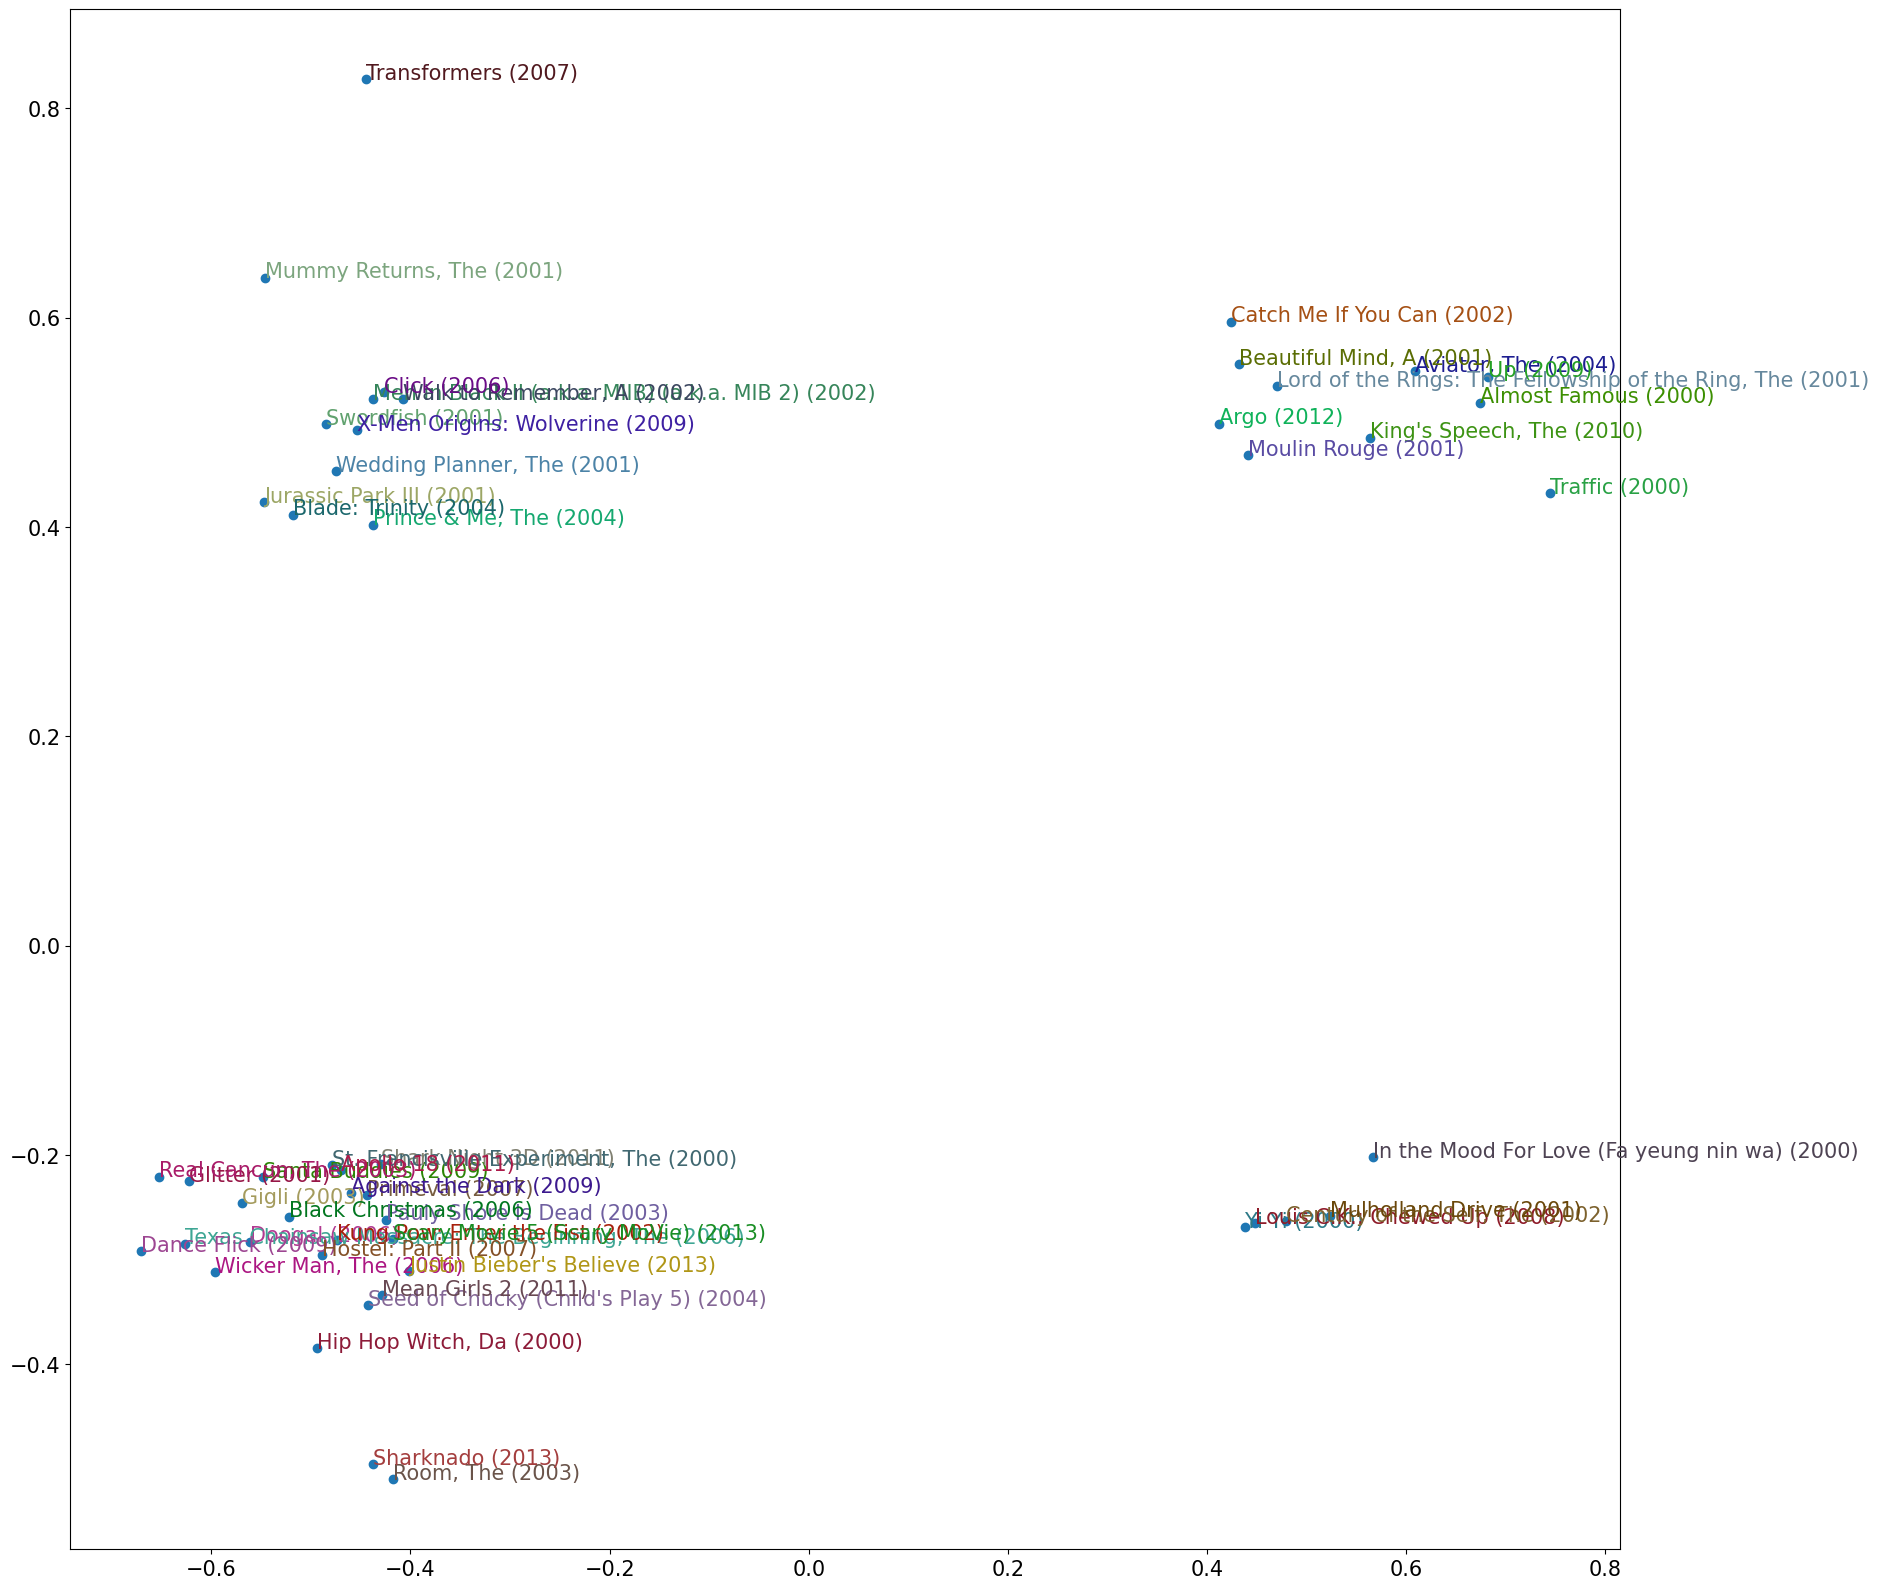

In [20]:
#idxs = np.random.choice(len(top_movies), 50, replace=False)
#idxs = list(range(50))
plt.figure(figsize=(20,20))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)


X = m_emb_df_sample['pca_1'] #fac0[idxs]
Y = m_emb_df_sample['pca_2'] #fac2[idxs]
plt.scatter(X, Y)
for i, x, y in zip(list(m_emb_df_sample['title']), X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=15)
plt.show()